# Case study forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
np.random.seed(42)

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


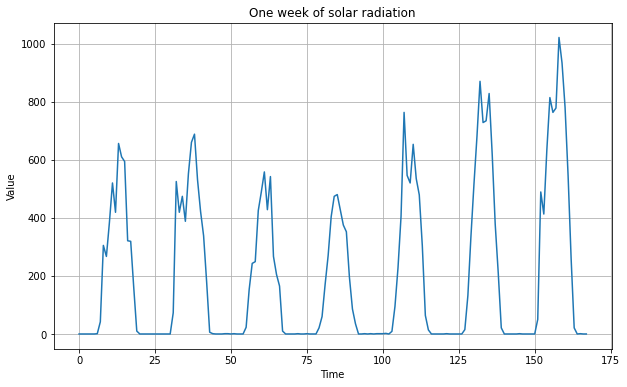

In [3]:
GHI = pd.read_csv('./data/GHI_sa.csv')

def plot_series(series, format="-", start=0, end=None, title = ''):
    plt.plot(series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(np.array(GHI), end=168, title='One week of solar radiation' )

## Forecasting
### Preprocessing and dividing into training, test, and validation sets and normalizing data

In [4]:
split_time_training = 122640
split_time_validation = 148920
x = np.array(GHI)

scaler = StandardScaler()
scaler = scaler.fit(x.reshape(-1,1))
x = scaler.transform(x.reshape(-1,1))


x_train = x[:split_time_training]
x_valid = x[split_time_training:split_time_validation]
x_test = x[split_time_validation:]


def windowed_dataset(series, n_steps_in_d, n_steps_out_d,  batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis = -1)
    #print(series)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(n_steps_in_d + n_steps_out_d, shift=1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(n_steps_in_d + n_steps_out_d))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[0:n_steps_in_d], w[n_steps_in_d:]))
    
    return ds.batch(batch_size).prefetch(1)

n_steps_in_d = 168 # number of steps for the input of the network
n_steps_out_d = 24 # number of steps for the output of the network
batch_size = 128
shuffle_buffer_size = 1000


train_set = windowed_dataset(x_train, n_steps_in_d, n_steps_out_d, batch_size = batch_size, shuffle_buffer = shuffle_buffer_size)

validation_set = windowed_dataset(x_valid, n_steps_in_d, n_steps_out_d, batch_size = batch_size, shuffle_buffer = shuffle_buffer_size)

test_set = windowed_dataset(x_test, n_steps_in_d, n_steps_out_d, batch_size = batch_size, shuffle_buffer = shuffle_buffer_size)

In [13]:
counter = 0
for element in train_set.as_numpy_iterator():
    counter = counter + 1
print("You generated {} batches of size {} ".format(counter, batch_size))
print('Your training dataset is then composed of around {} sequences'.format(counter*batch_size))

You generated 957 batches of size 128 
Your training dataset is then composed of around 122496 sequences


## Training the model with the optimizer and LR defined in previous step

In [7]:
model_train = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(16, 
                           kernel_size=16, 
                           strides=1, 
                           padding='causal', 
                           activation='relu',
                           input_shape=[n_steps_in_d,1]),
    tf.keras.layers.LSTM(24, return_sequences=False, input_shape=[n_steps_in_d,1]), # si puesiera return sequence, sería del mismo tamaño que
    tf.keras.layers.RepeatVector(n_steps_out_d),
    
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
])
model_train.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 168, 16)           272       
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                3936      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 24)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             25        
Total params: 8,937
Trainable params: 8,937
Non-trainable params: 0
_________________________________________________________________


In [8]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model_train.compile(loss='mse', optimizer='adam', metrics='mae')

#train the model
start = time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model_train.fit(train_set, epochs=100, validation_data=validation_set, verbose=1, callbacks=[early_stopping])
print("The model took {} seconds for training.".format(time() - start)) 

Epoch 1/100
957/957 [==============================] - 40s 37ms/step - loss: 0.3489 - mae: 0.4030 - val_loss: 0.1253 - val_mae: 0.2137
Epoch 2/100
957/957 [==============================] - 37s 38ms/step - loss: 0.1378 - mae: 0.2186 - val_loss: 0.1196 - val_mae: 0.2014
Epoch 3/100
957/957 [==============================] - 38s 40ms/step - loss: 0.1331 - mae: 0.2086 - val_loss: 0.1165 - val_mae: 0.1920
Epoch 4/100
957/957 [==============================] - 38s 39ms/step - loss: 0.1314 - mae: 0.2048 - val_loss: 0.1155 - val_mae: 0.1876
Epoch 5/100
957/957 [==============================] - 38s 40ms/step - loss: 0.1304 - mae: 0.2026 - val_loss: 0.1161 - val_mae: 0.1898
Epoch 6/100
957/957 [==============================] - 38s 40ms/step - loss: 0.1302 - mae: 0.2016 - val_loss: 0.1161 - val_mae: 0.1873
Epoch 7/100
957/957 [==============================] - 39s 40ms/step - loss: 0.1295 - mae: 0.1999 - val_loss: 0.1143 - val_mae: 0.1844
Epoch 8/100
957/957 [==============================] - 

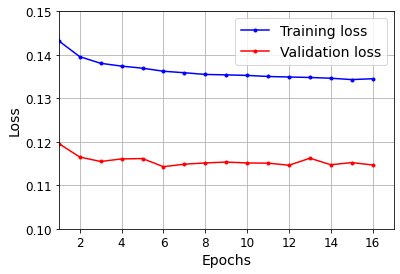

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, len(history.epoch), 0.1, 0.15])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Testing Model

In [208]:
def forecast_model(model, data):
    forecast = []
    for time in range(0,len(data) - (n_steps_in_d), n_steps_out_d):
        prediction = model_train.predict(np.array(data[time:time+n_steps_in_d]).reshape((1,-1,1)))[0]
        #remove_scaler = scaler.inverse_transform(prediction) 
        forecast.append(prediction)
    forecast = np.array(forecast).reshape(-1,1)
    
    mse = np.sqrt(mean_squared_error(scaler.inverse_transform(forecast), scaler.inverse_transform((data[n_steps_in_d::]))))
    mae = mean_absolute_error(scaler.inverse_transform(forecast), scaler.inverse_transform((data[n_steps_in_d::])))
    r2 = r2_score(scaler.inverse_transform(forecast), scaler.inverse_transform((data[n_steps_in_d::])))
    
    print('Root mean square error: ', mse)
    print('Mean absolute error: ', mae)
    print('R-Squared: ', r2)
    
    return forecast

## Training metrics

In [211]:
forecast_train = forecast_model(model_train, x_train)

Root mean square error:  110.55199164699988
Mean absolute error:  59.86458307020519
R-Squared:  0.8372372333218254


## Validation metrics

In [209]:
forecast_validation = forecast_model(model_train, x_valid)

Root mean square error:  100.906572208137
Mean absolute error:  55.08389202526757
R-Squared:  0.8533925848878517


In [179]:
model_train.evaluate(validation_set)

204/204 [==============================] - 7s 31ms/step - loss: 0.1143 - mae: 0.1844


[0.11427853256464005, 0.18441970646381378]

## Testing metrics

In [210]:
forecast_testing = forecast_model(model_train, x_test)

Root mean square error:  106.570515621876
Mean absolute error:  58.724496710036306
R-Squared:  0.8464504975422373


In [177]:
model_train.evaluate(test_set)

204/204 [==============================] - 7s 30ms/step - loss: 0.1263 - mae: 0.1953


[0.12627261877059937, 0.19526273012161255]

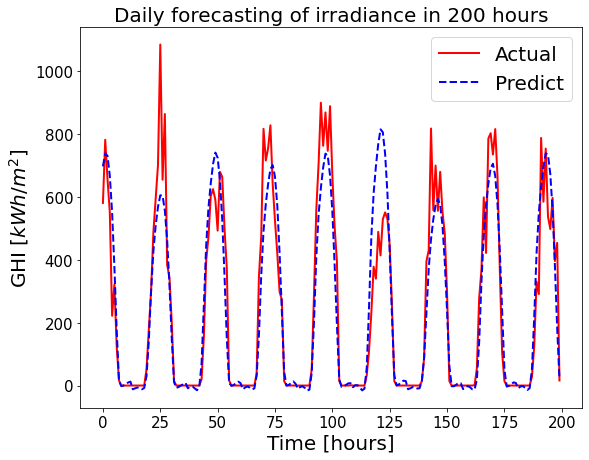

In [199]:
start=300
end=500


plt.figure(figsize=(9,7))
plt.plot(scaler.inverse_transform(x_test[n_steps_in_d::])[start:end] , 'r', label='Actual', linewidth=2)
plt.plot(scaler.inverse_transform(forecast)[start:end], 'b--', label='Predict', linewidth=2)
plt.legend(loc='best', fontsize=20)
plt.xlabel('Time [hours]', fontsize=20)
plt.ylabel('GHI $[kWh/m^2]$', fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title('Daily forecasting of irradiance in {} hours'.format(end-start), fontsize=20)
plt.savefig('img/daily_forecasting_CNN_LSTM.png')

## Saving model

In [195]:
model_train.save('models/daily_forecasting/daily_forecasting_CNN_LSTM_model.h5')